In [1]:
%load_ext autoreload

In [1253]:
%autoreload

import audl_advanced_stats as audl
import numpy as np
import pandas as pd
import plotly.express as px

In [1254]:
s = audl.Season()
s.get_games(override=False).iloc[:10]#["url"].values

,game_date,away_team,home_team,url
0,2021-06-04,DC,NY,https://audl-stat-server.herokuapp.com/stats-p...
1,2021-06-04,DET,IND,https://audl-stat-server.herokuapp.com/stats-p...
2,2021-06-04,MIN,MAD,https://audl-stat-server.herokuapp.com/stats-p...
3,2021-06-04,TB,PHI,https://audl-stat-server.herokuapp.com/stats-p...
4,2021-06-05,AUS,DAL,https://audl-stat-server.herokuapp.com/stats-p...
5,2021-06-05,BOS,PIT,https://audl-stat-server.herokuapp.com/stats-p...
6,2021-06-05,IND,CHI,https://audl-stat-server.herokuapp.com/stats-p...
7,2021-06-05,MAD,DET,https://audl-stat-server.herokuapp.com/stats-p...
8,2021-06-05,RAL,ATL,https://audl-stat-server.herokuapp.com/stats-p...
9,2021-06-05,SD,LA,https://audl-stat-server.herokuapp.com/stats-p...


In [1255]:
g = audl.Game(s.games["url"].iloc[0])

In [1256]:
g.get_game_info()

,id,team_season_id_home,team_season_id_away,status_id,score_home,score_away,live,reg_season,lock,start_timestamp,start_timezone,start_time_tbd,aw_section,ext_game_id,update_timestamp
0,2702,210,220,101,19,18,None,True,True,2021-06-04T19:00:00.000Z,EDT,False,week-1,2021-06-04-DC-NY,2021-06-05T01:08:48.237Z


In [1257]:
g.get_away_roster().sort_values(["id"])

,id,team_season_id,player_id,jersey_number,first_name,last_name,ext_player_id,active
10,9066,220,1986,4,Houston,Parks,hparks,False
15,9067,220,2301,5,AJ,Merriman,amerriman,True
1,9068,220,454,6,Dane,Warner,dwarner,False
8,9069,220,1843,10,Zach,Norrbom,znorrbom,True
17,9070,220,2304,12,Garrett,Braun,gbraun,True
18,9071,220,2306,15,Kyle,Vezina,kvezina,True
25,9072,220,2484,18,Kevin,Healey,khealey,False
12,9075,220,1992,23,Gabe,Webster,gwebster,False
23,9076,220,2341,24,Jacques,Nissen,jnissen,True
20,9077,220,2320,25,Jeremy,Knopf,jknopf,False


Number of events: 437
New Event Types: 
Event Attributes: t, r, x, y, s


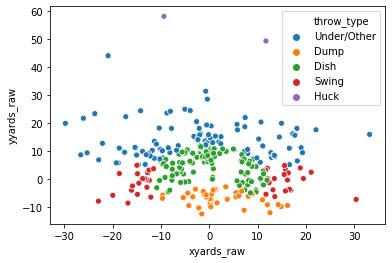

In [1258]:
import seaborn as sns
temp = g.get_away_events().query("t_after==[20,22]")
sns.scatterplot(data=temp, x="xyards_raw", y="yyards_raw", hue="throw_type")

In [1259]:
g.get_home_events().tail(20)[["t", "point_number", "possession_number", "possession_number_min", "possession_number_max", "num_turnovers"]]

Number of events: 359
New Event Types: 
Event Attributes: t, r, x, y, s


,t,point_number,possession_number,possession_number_min,possession_number_max,num_turnovers
339,21,39.0,59.0,58.0,59.0,1
340,1,40.0,60.0,60.0,60.0,0
341,20,40.0,60.0,60.0,60.0,0
342,20,40.0,60.0,60.0,60.0,0
343,20,40.0,60.0,60.0,60.0,0
344,20,40.0,60.0,60.0,60.0,0
345,20,40.0,60.0,60.0,60.0,0
346,20,40.0,60.0,60.0,60.0,0
347,20,40.0,60.0,60.0,60.0,0
348,20,40.0,60.0,60.0,60.0,0


In [1260]:
g.get_away_events().query("t_after==[20,22] & ~centering_pass").groupby(["r"])["yyards"].sum().sort_values()

r
9342.0     -6.83
9284.0      1.57
9079.0      9.47
9341.0     15.15
9282.0     15.47
9067.0     21.94
9343.0     31.61
9083.0     38.05
9080.0     52.34
9078.0     80.35
9345.0    140.28
9070.0    143.21
9286.0    149.94
9276.0    161.29
9076.0    164.61
9344.0    222.28
9069.0    231.96
Name: yyards, dtype: float64

In [1261]:
fig = g.visual_game_flow(color="o_point", home=True, qc=True)
fig

Segments w/ >7 players: 0


In [1262]:
fig = g.visual_possession_map(possession_number=1, home=False)
fig

In [1265]:
g.get_home_events()["play_description"].head(10).iloc[3]

'Completion: Ben Katz Under/Other to Josue Alorro for 9 yards'

In [1226]:
g.get_home_roster().assign(name=lambda x: x["first_name"].str.strip()
                        + " "
                        + x["last_name"].str.strip(),)[["id", "name"]].set_index("id").to_dict()["name"]

{9451: 'Ben Jagt',
 9463: 'Ben Katz',
 9468: 'Ben Nelson',
 9454: 'Conor Kline',
 9455: 'Jack Williams',
 9471: 'Jeff Babbitt',
 9457: 'Joe Ouellette',
 9550: 'Josue Alorro',
 9470: 'Marques Brownlee',
 9456: 'Matt LeMar',
 9459: 'Matt Stevens',
 9467: 'Matt Weintraub',
 9458: 'Mike Drost',
 9469: 'Ryan Drost',
 9461: 'Ryan Holmes',
 9448: 'Ryan Osgar',
 9449: 'Ryan Saffa',
 9462: 'Noriaki To',
 9452: 'TJ Stanton',
 9465: 'Ryan Weaver',
 9450: 'Elliott Chartock',
 9464: 'Sam Feder',
 9466: 'John Lithio',
 9460: 'Angelo Olcese',
 9453: 'Solomon Rueschemeyer-Bailey'}